# Data Exploration: Køge Dataset

This notebook contains the analysis of the signal data contained by the database provided by Jonas Munch Nielsen who is a PHD student.<br>

The Dataset is collected at childrens hospital of Boston. It contains EEG recordings 10 subjects. <br>
<br>
Notice that only files containing seizure timestamp are included.

The outline of this analysis is a follows: <br>

1. Reading and transforming the dataset to pandas Dataframe
2. Taking a look at the different features from the frequency and time domain.
3. Spectral analysis.
4. Building the model using the keras functional API.

## Importing Packages

In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import matplotlib
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from scipy import signal
plt.ioff()
import psutil
import gc
import glob
plt.style.use('ggplot')

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.4
Scikit-Learn 1.0.1
GPU is available


## Data Overview

In [2]:
cwd = os.getcwd()
database_path = '../../Dataset/EMU_monitor(ruc)/'
save_csv_path = '../../Dataset/EMU_monitor(ruc)/NHR/EEG'
edf_file_type = ".edf"
capitilize_edf_file_type = ".EDF"
bdf_file_type = ".BDF"
patient_one_path = 'chb04/'
info_df_path = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR_Eventlist_RUC.xlsx"
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
cwd

'/Users/niklashjort/Desktop/Notes/Speciale/projects/Master_Thesis_Project/Data_Analysis'

In [3]:
info_df = pd.read_excel(info_df_path, sheet_name="NHR_EEG")
info_df.head()

,patientID,time_emu,SeizureID,delay,seizureDuration,fileName
0,4,22-05-2019 02:45:22,1,83.000001,56,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
1,4,2019-05-22 03:50:49,2,83.000000,53,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
2,4,2019-05-22 05:27:56,3,81.000000,48,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
3,4,2019-05-22 07:07:04,4,81.000000,52,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
4,4,2019-05-22 07:51:24,5,81.000000,53,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...


Find seizure duration distribution across all patients

In [8]:
patient_list = info_df['patientID'].unique()

distr_sz = {}

for patient in patient_list:
  duration = 0
  for _, row in info_df.iterrows():
    if str(patient) == str(row['patientID']):
      duration += row['seizureDuration']
  distr_sz[f"{patient}"] = duration

distr_sz
    

{'4': 503,
 '6': 146,
 '24': 106,
 '28': 70,
 '30': 350,
 '21': 1417,
 '33': 95,
 '34': 109,
 '35': 41}

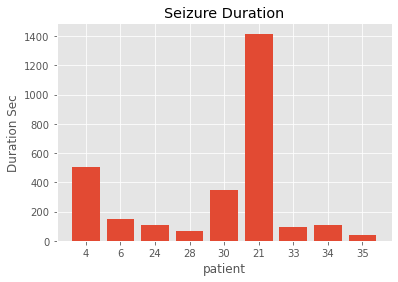

In [10]:
plt.bar(range(len(distr_sz)), list(distr_sz.values()), align="center")
plt.xticks(range(len(distr_sz)), list(distr_sz.keys()))
plt.title("Seizure Duration")
plt.xlabel('patient')
plt.ylabel('Duration Sec')
plt.show()

## Reading EEG DATA:

Sample: File information

In [11]:
def ReadEdfFile(file_name, print_reader_info = False):
    if edf_file_type in file_name or capitilize_edf_file_type in file_name:
        if(print_reader_info):
            data = mne.io.read_raw_edf(file_name)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            print(data.info)
            return converted_raw, data.info
        else:
            data = mne.io.read_raw_edf(file_name, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw, data.info
    if bdf_file_type in file_name:
        if(print_reader_info):
            data = mne.io.read_raw_bdf(file_name)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            print(data.info)
            return converted_raw, data.info
        else:
            data = mne.io.read_raw_edf(file_name, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw, data.info

In [ ]:
eeg_df, info = ReadEdfFile("") 